## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
from urllib.parse import urlparse
from scipy.stats import spearmanr

from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.optim import lr_scheduler

from tqdm import tqdm
from transformers import DistilBertTokenizer

from radam import RAdam
from text_data import TextDataset2, TextDataset3
from bert import CustomBert, HeadNet
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from sentence_embed import get_use_embedding_features, get_distill_bert_features
from create_features import get_dist_features, get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

Using TensorFlow backend.


## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
train = clean_data(train, INPUTS)
test = clean_data(test, INPUTS)

In [4]:
init_seed()

In [5]:
%%time
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
ids_train = {}
ids_test = {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text in INPUTS:
        ids = []
        for x in df[text].values:
            x = " ".join(x.strip().split()[:300])
            tok = tokenizer.encode(x, add_special_tokens=True)
            ids.append(tok[:max_seq_len])
        ids = np.array([i + [0] * (max_seq_len - len(i)) for i in ids])
        if mode == 'train': ids_train[text] = ids
        else: ids_test[text] = ids

Token indices sequence length is longer than the specified maximum sequence length for this model (586 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (643 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (713 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 20.3 s, sys: 2.27 ms, total: 20.3 s
Wall time: 20.7 s


In [6]:
%%time
distill_bert_feature_path = 'proc_data/distill_bert_features/'
bert_features_train, bert_features_test = get_distill_bert_features(
    train, test, ['question_body', 'answer'], 64, distill_bert_feature_path)

CPU times: user 1.1 s, sys: 64.1 ms, total: 1.16 s
Wall time: 1.16 s


In [7]:
%%time
use_feature_path = 'proc_data/use_embedding_features/'
embedding_train, embedding_test = get_use_embedding_features(train, test, INPUTS, use_feature_path)

CPU times: user 1.14 s, sys: 35.2 ms, total: 1.18 s
Wall time: 1.17 s


In [8]:
%%time
dist_features_train, dist_features_test  = get_dist_features(embedding_train, embedding_test)

CPU times: user 982 ms, sys: 18.9 ms, total: 1 s
Wall time: 101 ms


In [9]:
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [10]:
cat_features_train = np.hstack([train_host.reshape(-1, 1), train_category.reshape(-1, 1)])
cat_features_test = np.hstack([test_host.reshape(-1, 1), test_category.reshape(-1, 1)])
merged = np.vstack([cat_features_train, cat_features_test])
ohe = OneHotEncoder()
ohe.fit(merged)

cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [11]:
x_features_train = np.hstack([cat_features_train, dist_features_train])
x_features_test = np.hstack([cat_features_test, dist_features_test])

In [12]:
y = train[TARGETS].values.astype(np.float32)

In [13]:
num_workers = 10
bs = 4

In [14]:
bs_test = 4
test_loader = DataLoader(
    TextDataset2(x_features_test, embedding_test['question_body_embedding'], 
                 embedding_test['answer_embedding'], embedding_test['question_title_embedding'], 
                 ids_test['question_body'], ids_test['answer'], ids_test['question_title'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers
)

## Training model

In [15]:
lr = 0.001
lr2 = 0.00001
loss_fn = nn.BCEWithLogitsLoss()
device = torch.device('cuda')
n_epochs = 6
model_name = 'distil_bert'
checkpoint_dir = 'checkpoints/'
early_stopping = None

In [16]:
def get_optimizer(lr):
    return optim.Adam([#params=model.parameters(), lr=lr)#[
                {'params': model.head.parameters(), 'lr': lr},
                {'params': model.q_bert.parameters(), 'lr': lr/100},
                {'params': model.a_bert.parameters(), 'lr': lr/100}
            ])

def get_optimizer2(lr):
    return RAdam(params=model.parameters(), lr=lr)#[
                #{'params': model.head.parameters(), 'lr': lr},
                #{'params': model.q_bert.parameters(), 'lr': lr/10},
                #{'params': model.a_bert.parameters(), 'lr': lr/10}
            #])

Fold 1 started at Fri Dec  6 07:46:40 2019


  0%|          | 0/800 [00:00<?, ?it/s]/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
 79%|███████▉  | 632/800 [01:53<00:31,  5.33it/s]

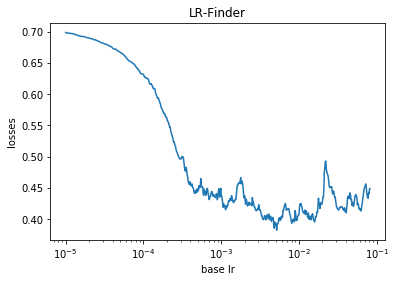

epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.46937 - spearmanr 0.11239
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.39769 - spearmanr 0.30794
best model: epoch 0 - 0.30794
epoch 1: 	 Start training...


In [ ]:
folds = KFold(n_splits=5, random_state=42)
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds.split(train)):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
#     train_loader = DataLoader(
#         TextDataset3(x_features_train, embedding_train['question_body_embedding'], 
#                      embedding_train['answer_embedding'], embedding_train['question_title_embedding'], 
#                      bert_features_train['question_body'], bert_features_train['answer'],
#                      train_index, y),
#         batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True
#     )
#     valid_loader = DataLoader(
#         TextDataset3(x_features_train, embedding_train['question_body_embedding'], 
#                      embedding_train['answer_embedding'], embedding_train['question_title_embedding'], 
#                      bert_features_train['question_body'], bert_features_train['answer'], 
#                      valid_index, y),
#         batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True
#     )
        
#     model = HeadNet(n_h=256)
#     model.to(device)
    train_loader = DataLoader(
        TextDataset2(x_features_train, embedding_train['question_body_embedding'], 
                     embedding_train['answer_embedding'], embedding_train['question_title_embedding'], 
                     ids_train['question_body'], ids_train['answer'], ids_train['question_title'], 
                     train_index, y),
        batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True
    )
    valid_loader = DataLoader(
        TextDataset2(x_features_train, embedding_train['question_body_embedding'], 
                     embedding_train['answer_embedding'], embedding_train['question_title_embedding'], 
                     ids_train['question_body'], ids_train['answer'], ids_train['question_title'], 
                     valid_index, y),
        batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True
    )
        
    model = CustomBert(256)
    model.to(device)
    
    if fold_id == 0:
        optimizer = get_optimizer(lr)
        lr_finder = LRFinder(n_iter=800, start_lr=1e-5, end_lr=1, device=device, grad_accum=8)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(lr)
    #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=8,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    learner.train()
    
    # 2nd stage
    
#     train_loader = DataLoader(
#         TextDataset2(x_features_train, embedding_train['question_body_embedding'], 
#                      embedding_train['answer_embedding'], embedding_train['question_title_embedding'], 
#                      ids_train['question_body'], ids_train['answer'], ids_train['question_title'], 
#                      train_index, y),
#         batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True
#     )
#     valid_loader = DataLoader(
#         TextDataset2(x_features_train, embedding_train['question_body_embedding'], 
#                      embedding_train['answer_embedding'], embedding_train['question_title_embedding'], 
#                      ids_train['question_body'], ids_train['answer'], ids_train['question_title'], 
#                      valid_index, y),
#         batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True
#     )
#     learner.train_loader = train_loader
#     learner.valid_loader = valid_loader
        
#     model = CustomBert(256)
#     model.to(device)
    
#     learner.load_best_model()
#     model.head = learner.model
#     learner.model = model
#     learner.optimizer = get_optimizer2(lr2)
#     learner.scheduler = OneCycleLR(learner.optimizer, n_epochs=n_epochs, n_batches=len(train_loader))
# #     learner.scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)
# #     learner.early_stopping = 5
# #     learner.n_epochs *= 2
# #     learner.batch_step_scheduler = False
#     learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / folds.n_splits
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#0.3982

In [ ]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [ ]:
sample_submission.head()